In [1]:
import numpy as np
from pathlib import Path

from tqdm import tqdm

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
from PIL import Image
from torchvision.transforms import ToTensor
from models.vae_dataset import VAENpDataset
from models.vae import ResVAE
from torch import optim

In [3]:
dataset = VAENpDataset(path_to_np_files="data", img_size=96)

100%|██████████| 14/14 [00:00<00:00, 14.75it/s]


In [14]:
def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    print(f'Checkpoint loaded: {path}, resuming from epoch {start_epoch}')
    return start_epoch, loss

In [15]:
resvae = ResVAE(3, 96, hidden_dim=256, z_dim=32)
optimizer = optim.Adam(resvae.parameters(), lr=0.00001)

In [16]:
_, _ = load_checkpoint(resvae, optimizer, './checkpoints/checkpoint_epoch_4.pt', "cpu")

Checkpoint loaded: ./checkpoints/checkpoint_epoch_4.pt, resuming from epoch 4


In [17]:
x = dataset[0]

In [18]:
x.max()

tensor(0.8941)

In [19]:
a,b,c = resvae.forward(x.unsqueeze(0))

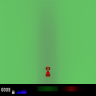

In [20]:
Image.fromarray((resvae.forward(x.unsqueeze(0))[0].squeeze(0).detach().numpy().transpose(1,2,0).astype(np.float32)*255).astype(np.uint8))

In [11]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [11]:
optimizer = optim.Adam(resvae.parameters(), lr=0.00001)

In [12]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [ ]:
for epoch in range(100):
    loop = tqdm(enumerate(dataloader))
    for i, x in loop:
        x_recon, mu, sigma = resvae(x)

        rec_loss = loss_fn(x_recon, x)
        kl_div = -0.5*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        beta = 0.0001

        loss = rec_loss + (kl_div*beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(full_loss=loss.item(), kl=kl_div.item(), rec_loss=rec_loss.item())

In [ ]:
x = dataset[0].unsqueeze(0)

In [ ]:
Image.fromarray((resvae.forward(x)[0].squeeze(0).detach().numpy().transpose(1,2,0).astype(np.float32)*255).astype(np.uint8))

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

In [12]:
def create_vae_animation(npz_path, vae_model, save_path="vae_reconstruction.gif", num_frames=400):
    """
    npz_path: путь к файлу с данными (предполагаем ключ 'obs')
    vae_model: ваша загруженная модель (torch.nn.Module)
    save_path: куда сохранить гифку
    num_frames: сколько кадров анимировать
    """

    # 1. Загрузка данных
    print(f"Загрузка данных из {npz_path}...")
    data = np.load(npz_path)

    # Предполагаем, что картинки лежат по ключу 'obs' или 'observations'
    # Если у вас другой ключ, поменяйте его здесь
    key = 'obs' if 'obs' in data else list(data.keys())[0]
    observations = data[key] # Ожидаем форму (N, 96, 96, 3) или (N, 64, 64, 3)

    # 2. Подготовка модели
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae_model.to(device)
    vae_model.eval() # Переключаем в режим оценки (выключает dropout и т.д.)

    # 3. Настройка графика
    fig, ax = plt.subplots()
    ax.axis('off') # Убираем оси координат

    # Инициализация пустой картинки
    # Берем первый кадр просто чтобы узнать размер
    img_plot = ax.imshow(observations[0])

    print("Генерация анимации...")

    def update(frame_idx):
        # --- ПРЕПРОЦЕССИНГ ---
        # Берем кадр из датасета. Он сейчас (H, W, C) и 0-255 uint8
        raw_frame = observations[frame_idx]

        # Конвертируем в формат PyTorch: (1, C, H, W) и нормализуем 0-1
        # permute(2, 0, 1) делает из HWC -> CHW
        input_tensor = torch.from_numpy(raw_frame).permute(2, 0, 1).float() / 255.0

        # Добавляем Batch dimension -> (1, C, H, W)
        x = input_tensor.unsqueeze(0).to(device)

        # --- ВАШ КОД + ИНФЕРЕНС ---
        with torch.no_grad(): # Отключаем градиенты для скорости
            # ВАШ СНИППЕТ ВСТАВЛЕН СЮДА
            # x подается в VAE, на выходе реконструированная картинка

            # Примечание: Ваш сниппет возвращает PIL Image.
            # Matplotlib хочет numpy array. Поэтому оборачиваем в np.array()
            reconstructed_pil = Image.fromarray(
                (resvae(x)[0].squeeze(0).cpu().detach().numpy().transpose(1,2,0).astype(np.float32)*255).astype(np.uint8)
            )

            reconstructed_img = np.array(reconstructed_pil)

        # Обновляем картинку на графике
        img_plot.set_data(reconstructed_img)
        ax.set_title(f"Frame: {frame_idx}")
        return [img_plot]

    # Создание анимации
    # frames=num_frames ограничивает длину, чтобы не рендерить весь датасет часами
    ani = FuncAnimation(fig, update, frames=range(num_frames), blit=True)

    # Сохранение
    print(f"Сохранение в {save_path}...")
    ani.save(save_path, fps=20, writer='pillow') # 'pillow' сохраняет gif
    print("Готово!")
    plt.close()

In [13]:
path_to_npz = "data/car_racing_data_ep_12.npz" # Или "data_1.npz"

# 2. Здесь должна быть инициализация вашей модели

# ПРОВЕРКА: Если модели нет под рукой, код упадет.
    # Раскомментируйте строку ниже для запуска функции, если vae уже определен в вашем коде
create_vae_animation(path_to_npz, resvae)

Загрузка данных из data/car_racing_data_ep_12.npz...
Генерация анимации...
Сохранение в vae_reconstruction.gif...
Готово!


In [1]:
x

NameError: name 'x' is not defined